# 3. Applying a cut to a sample and calculating the efficiency

In this example, we learn how to apply a cut in `pandas` and how to calculate the efficiency of the cut. We see how to calculate the uncertainty on the cut using the binomial error.

Some imports of what we need:

In [1]:
from root_pandas import read_root
import matplotlib.pyplot as plt
from bd2dst3pi.locations import loc
from bd2dst3pi.definitions import years, magnets
import pandas as pd
from bd2dst3pi.stats import binomial_err
import numpy as np
import scipy.stats as stats

#Gives us nice LaTeX fonts in the plots
from matplotlib import rc
rc('font',**{'family':'serif','serif':['Roman']})
rc('text', usetex=True)

Welcome to JupyROOT 6.22/02


Let's load the data for each year and magnet into separate DataFrames, storing them in a useful dictionary called `df`. This is just an example of how to do this, as it can be useful to work with dictionaries. We also make a total DataFrame `dt_tot` containing all years and magnets:

In [2]:
df = {}
df_tot = pd.DataFrame()
tree_name = "DecayTree"
for y in years:
    for m in magnets:
        df[f"{y}_{m}"] = read_root(f"{loc.DATA}/data_90000000_{y}_{m}.root",tree_name)
        df_tot = df_tot.append(df[f"{y}_{m}"])

We can access a specific year and magnet:

In [3]:
print(df["2015_up"].head(2))

   B0_ENDVERTEX_X  B0_ENDVERTEX_Y  B0_ENDVERTEX_Z  B0_ENDVERTEX_XERR  \
0         -1.7246         -0.6828         60.6567             0.0172   
1          2.4748          1.2210         43.5751             0.0166   

   B0_ENDVERTEX_YERR  B0_ENDVERTEX_ZERR  B0_ENDVERTEX_CHI2  B0_ENDVERTEX_NDOF  \
0             0.0086             0.1807           0.772943                  3   
1             0.0108             0.1405          15.108430                  3   

                                   B0_ENDVERTEX_COV_  B0_OWNPV_X  ...  \
0  [[0.00029584, 9.775047e-05, -0.0029697323], [9...      0.7643  ...   
1  [[0.00027556, 0.00013472892, 0.0022361316], [0...      0.7717  ...   

   DstD_BDTD  combinatorial_BDTG  combinatorial_BDT  combinatorial_BDTD  \
0   0.237036            0.812131           0.201764            0.155237   
1  -0.214430            0.559392           0.159562            0.198848   

   detachment_BDTG  detachment_BDT  detachment_BDTD isolation_BDTG  \
0        -0.786932     

In this example, we have loaded all of the variables in the `TTree`, and the printout above shows a summary of some of them for the first 2 events in the tree. 

Let's calculate the flight of the $\tau$ candidate along the $z$-axis. In our data sample, which has aready had selections applied to keep $B^0 \to D^{*-} \pi^+ \pi^+ \pi^-$ decays, we won't have any genuine $\tau \to \pi^+ \pi^+ \pi^- \nu$ candidates! The three pions produced in the $B^0 \to D^{*-} \pi^+ \pi^+ \pi^-$ decay come directly from the $B^0$ decay vertex. Thus, the only flight we should see along the $z$-axis is due to measurement uncertainties on the vertices. 

In [4]:
df_tot["tau_flight_z"] = df_tot["tau_ENDVERTEX_Z"] - df_tot["B0_ENDVERTEX_Z"]

Let's make a quick plot of the $\tau$ candidate flight:

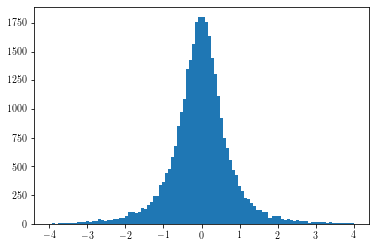

In [5]:
plt.hist(df_tot["tau_flight_z"], bins=100, range=(-4,4))
plt.show()

Indeed we find that the flight is on average zero, but with some spread. The spread is due to measurement uncertainties on the $B$ and $\tau$ vertex.

We can also calculate the flight in units of standard deviations (flight significance), by using the measured uncertainties on the $B$ and $\tau$ vertices:

In [6]:
df_tot["tau_flight_zerr"] = np.sqrt(df_tot["tau_ENDVERTEX_ZERR"]**2 + df_tot["B0_ENDVERTEX_ZERR"]**2)
df_tot["tau_flight_zsig"] = df_tot["tau_flight_z"] / df_tot["tau_flight_zerr"]

We can compare the flight significance with a standard normal distribution, which has a mean of zero and a width of 1:

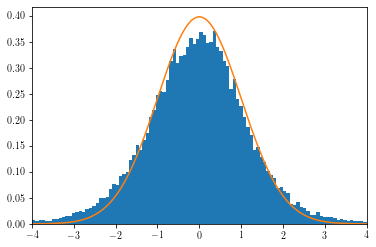

In [7]:
low = -4
high = 4
n_bins = 100
plt.hist(df_tot["tau_flight_zsig"], bins=n_bins, range=(low,high), density=True)
norm_mu = 0.
norm_sigma = 1.
x = np.linspace(norm_mu - high*norm_sigma, norm_mu + high*norm_sigma, 1000)
plt.plot(x, stats.norm.pdf(x, norm_mu, norm_sigma))
plt.xlim(low,high)
plt.show()

We see that the flight significance is indeed pretty normally distributed. The fact that the distribution has a mean of zero tells us that, on average, our three pions have zero flight from the $B$ vertex. This is consistent with the decays genuinely being $B^0 \to D^{*-} \pi^+ \pi^+ \pi^-$.

Let's count the fraction of decays which have a flight significance of more than $\pm2$ standard deviations. We expect this to be around 5\% for a perfectly normally distributed sample:

In [8]:
df_cut = df_tot.query("abs(tau_flight_zsig) >= 2")
n_pass = len(df_cut)
n_tot = len(df_tot)
print(f"Number with high flight significance: {n_pass}")
print(f"Total number: {n_tot}")

Number with high flight significance: 3349
Total number: 31573


We can calculate the efficiency of this cut by taking the ratio. The absolute uncertainty on this efficiency is given by the binomial formula $\sigma_\epsilon =  \frac{1}{N}\sqrt{N\times \frac{k}{N}(1 - \frac{k}{N}})= \frac{1}{N}\sqrt{k(1 - \frac{k}{N})}$. Code for calculating this error given a number passing the cut ($k$) and the total number ($N$) is provided in `bd2dst3pi/stats.py`.

In [9]:
eff = n_pass / n_tot
eff_err = binomial_err(n_tot, n_pass)
print(f"Efficiency of abs(tau_flight_zsig) >= 2 cut: {eff:.3f} +/- {eff_err:.3f}")

Efficiency of abs(tau_flight_zsig) >= 2 cut: 0.106 +/- 0.002


The efficiency is actually higher than 5%, because our distribution of flight significance is not quite normal (you can see it has tails at larger values in the plot above).

**Follow-up tasks**

- How does the flight significance look in MC? Is the distribution similar to the data?
- Compare the efficiency of the flight cut in data and MC. Which one is higher, and why could that be?
- Can you calculate the 3-dimensional flight distance? You can use Pythagoras theorem to help, so $L = \sqrt{x^2 + y^2 + z^2}$. How about the 3-dimensional flight significance?

## Task 1 - How does the flight significance look in MC? Is the distribution similar to the data?

First, I create a function to retrieve the data in the form of a panda df, and I retrieve it

In [10]:
def load_data(years,magnets,type_data = 'data'):
    """
    type_data = 'MC' or 'data'
    """
    if type_data == 'MC':
        path = f"{loc.MC}/Bd_Dst3pi_11266018"
        ext = '_Sim09e-ReDecay01.root'
    elif type_data == 'data':
        path = f"{loc.DATA}/data_90000000"
        ext = '.root'
    elif type_data == 'MCc':
        path = f"{loc.MC}/Bd_Dst3pi_11266018"
        ext = '_Sim09c-ReDecay01.root'
    elif type_data == 'MCe':
        path = f"{loc.MC}/Bd_Dst3pi_11266018"
        ext = '_Sim09e-ReDecay01.root'
    else:
        print('Choose your side')
    
    dfr = {}
    dfr_tot = pd.DataFrame()
    tree_name = "DecayTree"
    for y in years:
        for m in magnets:
            dfr[f"{y}_{m}"] = read_root(f"{path}_{y}_{m}{ext}",tree_name)
            print(f"{path}_{y}_{m}{ext}")
            dfr_tot = dfr_tot.append(dfr[f"{y}_{m}"])
    return dfr, dfr_tot

In [11]:
df_MC, df_tot_MC = load_data(years,magnets,type_data = 'MC')
df, df_tot = load_data(years,magnets,type_data = 'data')

/eos/lhcb/wg/semileptonic/RXcHad/B02Dsttaunu/Run2/ntuples//norm/Bd_Dst3pi/Bd_Dst3pi_11266018_2015_up_Sim09e-ReDecay01.root
/eos/lhcb/wg/semileptonic/RXcHad/B02Dsttaunu/Run2/ntuples//norm/Bd_Dst3pi/Bd_Dst3pi_11266018_2015_down_Sim09e-ReDecay01.root
/eos/lhcb/wg/semileptonic/RXcHad/B02Dsttaunu/Run2/ntuples//norm/Bd_Dst3pi/Bd_Dst3pi_11266018_2016_up_Sim09e-ReDecay01.root
/eos/lhcb/wg/semileptonic/RXcHad/B02Dsttaunu/Run2/ntuples//norm/Bd_Dst3pi/Bd_Dst3pi_11266018_2016_down_Sim09e-ReDecay01.root
/eos/lhcb/wg/semileptonic/RXcHad/B02Dsttaunu/Run2/ntuples//norm/data/data_90000000_2015_up.root
/eos/lhcb/wg/semileptonic/RXcHad/B02Dsttaunu/Run2/ntuples//norm/data/data_90000000_2015_down.root
/eos/lhcb/wg/semileptonic/RXcHad/B02Dsttaunu/Run2/ntuples//norm/data/data_90000000_2016_up.root
/eos/lhcb/wg/semileptonic/RXcHad/B02Dsttaunu/Run2/ntuples//norm/data/data_90000000_2016_down.root


In [12]:
print(len(df_tot['B0_M']))
print(len(df_tot_MC['B0_M']))

31573
23692


Now, I copy the function to plot histograms, from the notebook 2.

In [13]:
def list_into_string(L, sep = '_'):
    string = ""
    for l in L:
        string += str(l)
        string += sep
    return string[:-len(sep)]

def plot_hist(dfs, variable, name_variable, unit_variable, n_bins = 100, mode_hist = False, low = None, high = None):
    """
    Plot the histogram of particle_variable, with number of bins = 100
    
    If df is a dictionnary:
    dfs={name_data:panda_dataframe,...}
    --> Plot several histograms in the same plot
    
    if mode_hist is on, I use histograms with density = True/False
    
    """
    
    density = len(dfs)>1 # if there are more than 2 histograms
    
    fig, ax = plt.subplots(figsize=(8,6))
    name_datas = list(dfs.keys())
        
    # Some features of the variable/particle
#     units_var = variables[variable]['unit']
#     name_var = variables[variable]['name']
    #name_particle = particle_names[particle]
    
    
    # Compute the number of bins
    #bin_width = 4
    
    #First loop to determine the low and high value
    define_low = low is None
    define_high = high is None
    if define_low or define_high:
        if define_low: 
            low = np.inf
        if define_high:
            high = -np.inf
        for name_data, df in dfs.items():
            if define_low:
                low = min(low,df[variable].min())
            if define_high:
                high = max(high,df[variable].max())

    bin_width = (high-low)/n_bins
    
    colors = ['r','b','g','k']
    k_col = 0
    
    labels = []
    for name_data, df in dfs.items():
        n_candidates = len(df[variable])
        label= f"{name_data}: {n_candidates} candidates" if density else None
        if mode_hist:
            alpha = 0.5 if density else 1            
            counts,_,_ = plt.hist(df[variable], range = [low,high],bins = n_bins, alpha = alpha,
                                  label = label, density = density)
            
        else:
            #Make the histogram, and get the bin centres and error on the counts in each bin
            counts, bin_edges = np.histogram(df[variable], n_bins, range=(low,high))
            bin_centres = (bin_edges[:-1] + bin_edges[1:])/2.
            #Plot the bin centres and counts in each bin
            err = np.sqrt(counts)
            if density:
                counts = counts/(n_candidates*bin_width)
                err = err/(n_candidates*bin_width)
            plt.errorbar(bin_centres, counts, yerr=err, fmt='o', color=colors[k_col], label = label)
        k_col += 1
              
    #Some plot style stuff
    #Set the x title
    plt.xlabel("%s [%s]" %(name_variable,unit_variable),fontsize=30)
    
    #Set the y-title, which is number of candidates per bin
    ylabel = "Proportion of candidates" if density else "Candidates"
    fontsize = 25 if density else 30
    plt.ylabel(f"{ylabel} / ({bin_width:.1g} {unit_variable})", fontsize=fontsize)

    #Set lower and upper range of the x-axis
    plt.xlim(low,high)
    
    #Get the default y-limits, then redefine the plot to start at 0 and give it a bit more space on top (with the 1.1x)
    ymin, ymax = plt.ylim()
    plt.ylim(0.,ymax*1.2)

    #Set the font size of the axis numbers
    ax.tick_params(axis='both', which='major', labelsize=25)

    #Legend
    if density:
        plt.legend(fontsize = 20)
    
    #Remove any space not needed around the plot
    plt.tight_layout()

    plt.show()

    #Save the plot as a PDF document into our PLOTS folder (output/plots as defined in bd2dst3pi/locations.py)
    fig.savefig(f"{loc.PLOTS}/{variable}_{list_into_string(name_datas)}.pdf")



I define some variables/particles.

In [14]:
variables = {
    'P' : {
        'name': "p",
        'unit': "MeV/c"
    },
    'PT': 
    {
        'name': "$p_T$",
        'unit': "MeV/c"
    },
    'M': 
    {
        'name': "$m$",
        'unit': "MeV/$c^2$"
    },
    'flight_z':
    {
        'name': "$\Delta z$",
        'unit': "$\mu m$"
    },
    'flight_zsig':
    {
        'name': "$\Delta z$ significance",
        'unit': ""
    }
    
}

particle_names = {
    'B0':'$D^{*-}\pi^+\pi^+\pi^-$',
    'Dst':'$D^*$',
    'tau':'$\pi^+ \pi^+ \pi^-$'
}

def plot_hist_particle(dfs, particle, variable, n_bins = 100, mode_hist = False, 
                       low = None, high = None):
    name_variable = variables[variable]['name']
    unit_variable = variables[variable]['unit']
    
    plot_hist(dfs, f"{particle}_{variable}", name_variable, unit_variable, n_bins = n_bins, mode_hist = mode_hist,
             low = low, high = high)

We define 
- the flight distance *tau_flight_z*
- the error on the flight *distance tau_flight_zerr*
- the flight in units of standard deviations (**flight significance**): ratio between those two quantities *tau_flight_zsig*

In [15]:
for df_tot_e in df_tot_MC, df_tot:
    df_tot_e["tau_flight_z"] = df_tot_e["tau_ENDVERTEX_Z"] - df_tot_e["B0_ENDVERTEX_Z"]
    df_tot_e["tau_flight_zerr"] = np.sqrt(df_tot_e["tau_ENDVERTEX_ZERR"]**2 + df_tot_e["B0_ENDVERTEX_ZERR"]**2)
    df_tot_e["tau_flight_zsig"] = df_tot_e["tau_flight_z"] / df_tot_e["tau_flight_zerr"]

Now, we plot tau_flight_z and tau_flight_zsig

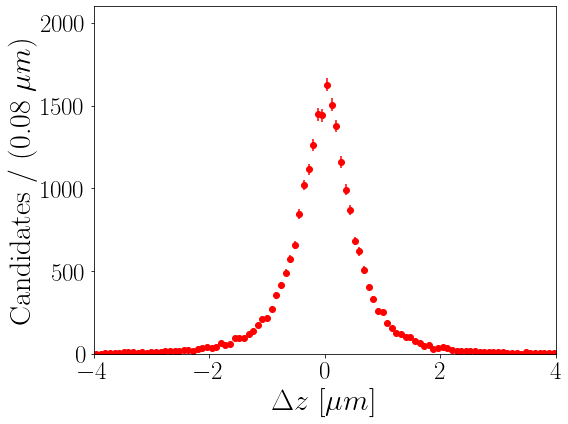

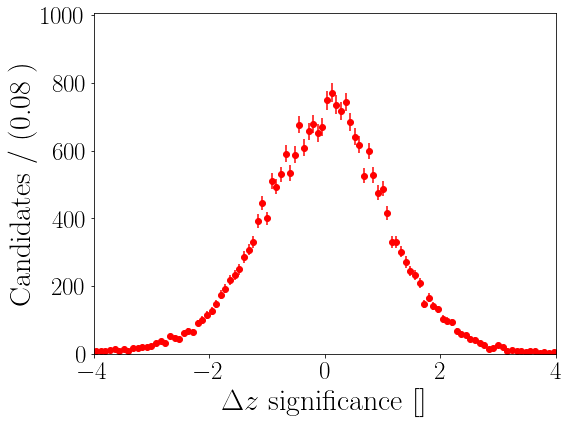

In [16]:
plot_hist_particle({'MC':df_tot_MC}, 'tau', 'flight_z', n_bins = 100, mode_hist = False, low = -4, high = 4)
plot_hist_particle({'MC':df_tot_MC}, 'tau', 'flight_zsig', n_bins = 100, mode_hist = False, low = -4, high = 4)
#plot_hist_particle({'data':df_tot}, 'tau', 'flight_zsig', n_bins = 100, mode_hist = False, low = -4, high = 4)

Now, let's compare the MC and data flight significance

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


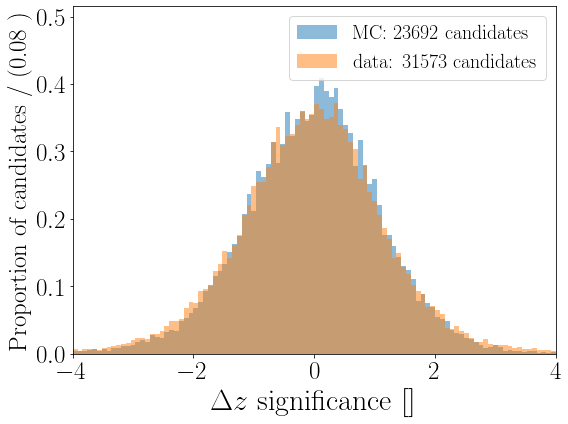

In [17]:
plot_hist_particle({'MC':df_tot_MC, 'data':df_tot}, 'tau', 'flight_zsig', n_bins = 100, low = -4, high = 4, mode_hist = True)

The data is a bit broader. We can check that by dividing one by the other as we did in the notebook 2.

In [18]:
def plot_divide(dfs, variable, name_variable,unit_variable, n_bins = 100, low = None, high = None):
    """
    dfs={name_data1:df1,name_data2:df2}
    plot the (histogram name_data1)/(histogram of namedata2) AFTER NORMALISATION ofc.
        
    """
       
    fig, ax = plt.subplots(figsize=(8,6))
    name_datas = list(dfs.keys())
    
    # Compute the number of bins
    #bin_width = 4
    
    ##First loop to determine the low and high value
    define_low = low is None
    define_high = high is None
    if define_low or define_high:
        if define_low: 
            low = np.inf
        if define_high:
            high = -np.inf
        for name_data, df in dfs.items():
            if define_low:
                low = min(low,df[variable].min())
            if define_high:
                high = max(high,df[variable].max())
    
    bin_width = (high-low)/n_bins
    
    labels = []
    #Make the histogram, and get the bin centres and error on the counts in each bin
    list_dfs = list(dfs.values())
    list_type_data = list(dfs.keys())
    counts1, bin_edges = np.histogram(list_dfs[0][variable], n_bins, range=(low,high))
    counts2, _ = np.histogram(list_dfs[1][variable], n_bins, range=(low,high))
    bin_centres = (bin_edges[:-1] + bin_edges[1:])/2.
    
    err1 = np.sqrt(counts1)
    err2 = np.sqrt(counts2)
    
    #division
    
    division = counts1*counts2.sum()/(counts2*counts1.sum()) 
    err = division*np.sqrt((err1/counts1)**2+(err2/counts2)**2)

    plt.errorbar(bin_centres, division, yerr=err, fmt='o', color='k')
    plt.plot([low,high], [1.,1.], linestyle='--', color='b',marker='')
    #Some plot style stuff
    #Set the x title
    plt.xlabel("%s[%s]" %(name_variable,unit_variable),fontsize=30)
    
    #Set the y-title, which is number of candidates per bin
    plt.ylabel("candidates[%s] / candidates[%s] \n / (%.1g {%s})"%(list_type_data[0],
                                                                   list_type_data[1],
                                                                   bin_width,
                                                                   unit_variable), 
               fontsize=30)

    #Set lower and upper range of the x-axis
    plt.xlim(low,high)
    
    #Get the default y-limits, then redefine the plot to start at 0 and give it a bit more space on top (with the 1.1x)
    ymin, ymax = plt.ylim()
    plt.ylim(0.,ymax*1.2)

    #Set the font size of the axis numbers
    ax.tick_params(axis='both', which='major', labelsize=25)

    
    #Remove any space not needed around the plot
    plt.tight_layout()

    plt.show()

    #Save the plot as a PDF document into our PLOTS folder (output/plots as defined in bd2dst3pi/locations.py)
    fig.savefig(f"{loc.PLOTS}/{variable}_{list_into_string(name_datas,'_d_')}.pdf")

def plot_divide_particle(dfs, particle, variable, n_bins = 100,low = None, high = None):
    name_variable = variables[variable]['name']
    unit_variable = variables[variable]['unit']
    
    plot_divide(dfs, f"{particle}_{variable}", name_variable, unit_variable, n_bins = n_bins,
             low = low, high = high)   

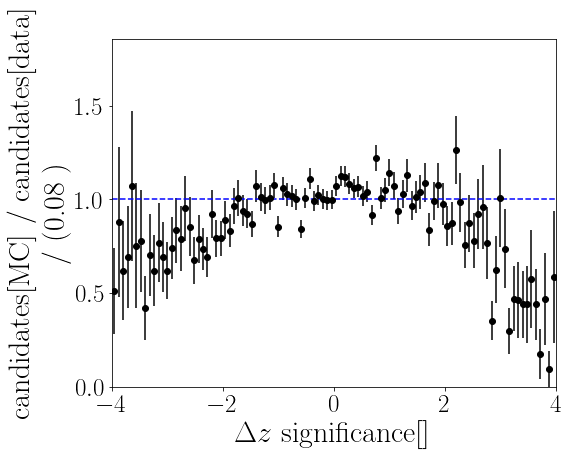

In [19]:
plot_divide_particle({'MC':df_tot_MC, 'data':df_tot}, 'tau', 'flight_zsig', 
                     n_bins = 100, low = -4, high = 4)

## Task 2 - Compare the efficiency of the flight cut in data and MC. Which one is higher, and why could that be?

In [20]:
def cut_efficiency(df_tot,condition):
    df_cut = df_tot.query(condition)
    n_pass = len(df_cut)
    n_tot = len(df_tot)
    print(f"Number with high flight significance: {n_pass}")
    print(f"Total number: {n_tot}")
    
    eff = n_pass / n_tot
    eff_err = binomial_err(n_tot, n_pass)
    print(f"Efficiency of abs(tau_flight_zsig) >= 2 cut: {eff:.3f} +/- {eff_err:.3f}")
    

In [21]:
print("======= MC ======= ")
cut_efficiency(df_tot_MC,"abs(tau_flight_zsig) >= 2")
print("====== data ====== ")
cut_efficiency(df_tot,"abs(tau_flight_zsig) >= 2")

======= MC ======= 
Number with high flight significance: 1800
Total number: 23692
Efficiency of abs(tau_flight_zsig) >= 2 cut: 0.076 +/- 0.002
====== data ====== 
Number with high flight significance: 3349
Total number: 31573
Efficiency of abs(tau_flight_zsig) >= 2 cut: 0.106 +/- 0.002


The efficiency of the cut on the data distribution is higher than the MC simulated distribution.

I guess that the MC one is the one we get if we only have signal (no background).
The already-reconstructed data has still some remaining background, that makes the flight distribution broaded.
By cutting on the data, we get a higher efficiency, that is, the proportion of events that is cut out is higher, since we also cut out background candidates.

## Task 3 - Can you calculate the 3-dimensional flight distance? You can use Pythagoras theorem to help, so $L = \sqrt{x^2 + y^2 + z^2}$. How about the 3-dimensional flight significance?

3-dimensional flight distance: $L = \sqrt{x^2+y^2+z^2}$

Error on $x^2$: $\delta(x^2)=2x \delta x$\
Error on $x^2+y^2+z^2$: $\delta(x^2+y^2+z^2)=2x \delta x+2y \delta y + 2z \delta z$\
Error on $L=\sqrt{x^2+y^2+z^2}$: $\delta L=\frac{x \delta x+y \delta y + z \delta z}{L}$


In [22]:
# We add some variables to the "variables" dictionnary
variables['flight']={'name': "$\Delta L$",'unit': "$\mu m$"}
variables['flight_sig']={'name': "$\Delta L$ significance",'unit': ""}

# We define the 3-dimensional flight distance
for df_tot_e in df_tot_MC, df_tot:
    for axis in 'X','Y','Z':
        variable_flight = f"tau_flight_{axis}"
        df_tot_e[f"tau_flight_{axis}"] = df_tot_e[f"tau_ENDVERTEX_{axis}"] - df_tot_e[f"B0_ENDVERTEX_{axis}"]
        df_tot_e[f"tau_flight_{axis}err"] = np.sqrt(df_tot_e[f"tau_ENDVERTEX_{axis}ERR"]**2 + df_tot_e[f"B0_ENDVERTEX_{axis}ERR"]**2)
        df_tot_e[f"tau_flight_{axis}sig"] = df_tot_e[f"tau_flight_{axis}"] / df_tot_e[f"tau_flight_{axis}err"]
    
    df_tot_e[f"tau_flight"] = np.sqrt(df_tot_e[f"tau_flight_X"]**2+df_tot_e[f"tau_flight_Y"]**2+df_tot_e[f"tau_flight_Z"]**2)
    
    df_tot_e[f"tau_flight_err"] = df_tot_e[f"tau_flight_X"]*df_tot_e[f"tau_flight_Xerr"]
    df_tot_e[f"tau_flight_err"] += df_tot_e[f"tau_flight_Y"]*df_tot_e[f"tau_flight_Yerr"]
    df_tot_e[f"tau_flight_err"] += df_tot_e[f"tau_flight_Z"]*df_tot_e[f"tau_flight_Zerr"]
    df_tot_e[f"tau_flight_err"] /= df_tot_e[f"tau_flight"]
    
    df_tot_e[f"tau_flight_sig"]=df_tot_e[f"tau_flight"]/df_tot_e[f"tau_flight_err"]
    
    

Now, we can plot its distribution

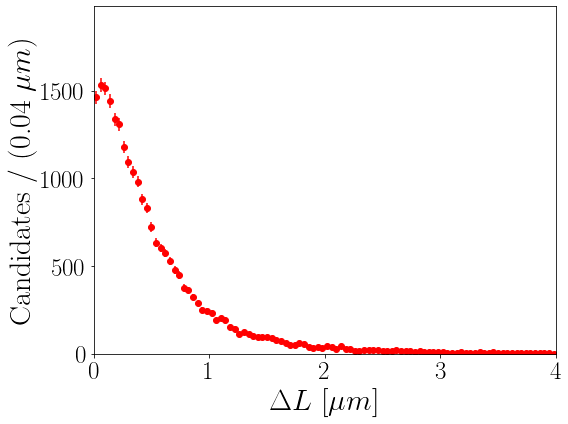

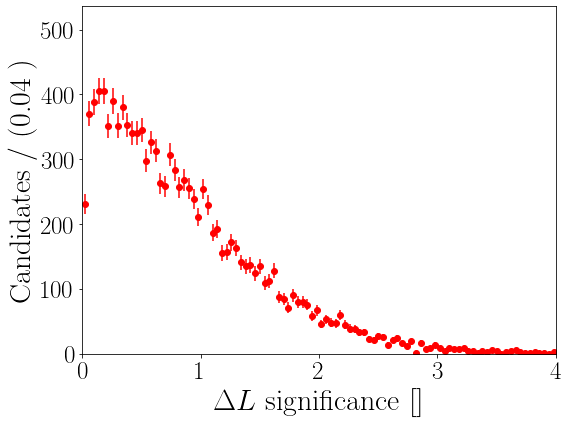

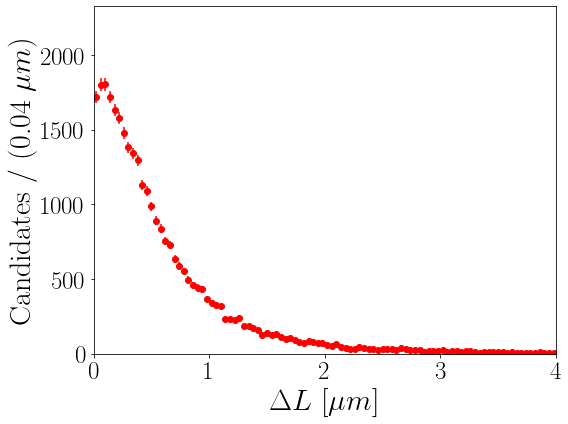

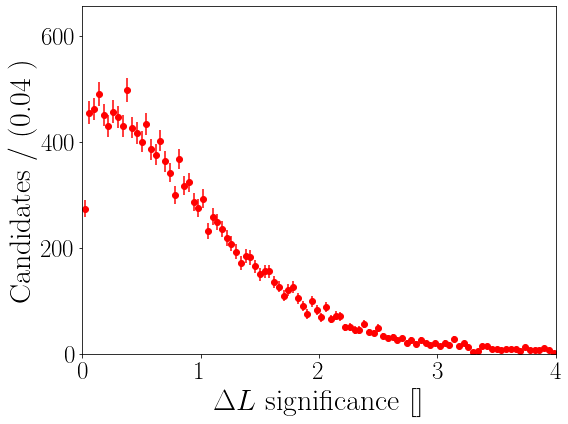

In [23]:
plot_hist_particle({'MC':df_tot_MC}, 'tau', 'flight', n_bins = 100, mode_hist = False, low = 0, high = 4)
plot_hist_particle({'MC':df_tot_MC}, 'tau', 'flight_sig', n_bins = 100, mode_hist = False, low = 0, high = 4)
plot_hist_particle({'data':df_tot}, 'tau', 'flight', n_bins = 100, mode_hist = False, low = 0, high = 4)
plot_hist_particle({'data':df_tot}, 'tau', 'flight_sig', n_bins = 100, mode_hist = False, low = 0, high = 4)


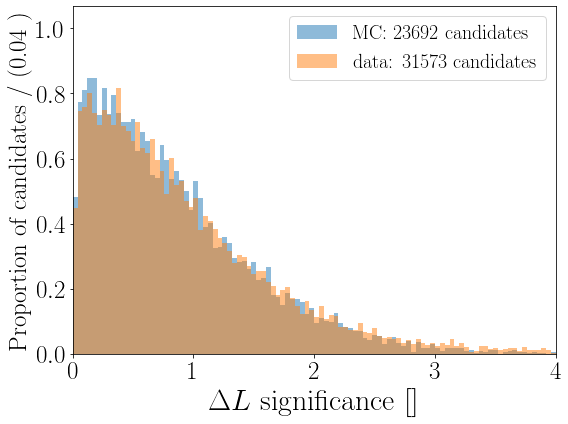

In [24]:
plot_hist_particle({'MC':df_tot_MC, 'data':df_tot}, 'tau', 'flight_sig', n_bins = 100, low = 0, high = 4, mode_hist = True)

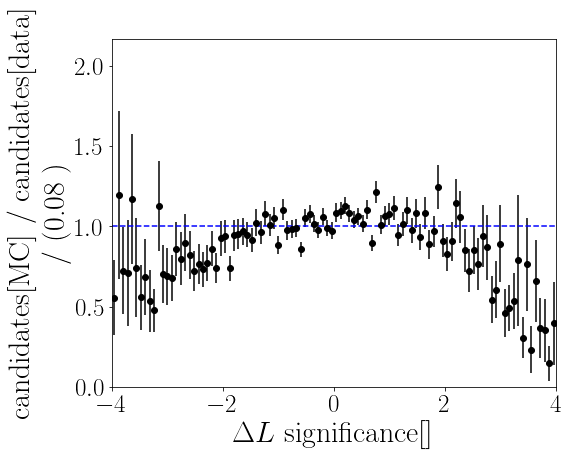

In [25]:
plot_divide_particle({'MC':df_tot_MC, 'data':df_tot}, 'tau', 'flight_sig', 
                     n_bins = 100, low = -4, high = 4)

In [26]:
print("======= MC ======= ")
cut_efficiency(df_tot_MC,"abs(tau_flight_sig) >= 2")
print("====== data ====== ")
cut_efficiency(df_tot,"abs(tau_flight_sig) >= 2")

======= MC ======= 
Number with high flight significance: 1888
Total number: 23692
Efficiency of abs(tau_flight_zsig) >= 2 cut: 0.080 +/- 0.002
====== data ====== 
Number with high flight significance: 3468
Total number: 31573
Efficiency of abs(tau_flight_zsig) >= 2 cut: 0.110 +/- 0.002
